In [2]:
from IPython.display import Image

# 卷积自编码

In [6]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [7]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


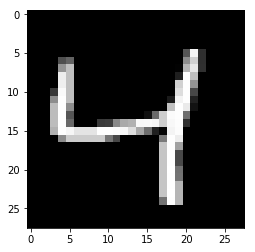

In [5]:
img = mnist.train.images[2]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

## 网络架构
　　网络的编码部分是一个典型的卷积金字塔结构。每个卷积层接着最大池化层，以减少层的维度。解码器需要将窄的显示转换为宽的重构图像，即将压缩表示的编码输出在解码为与输入很相似的重构图像。举例，该表示可以是 4x4x8 的最大池化层。编码的输出，同时也为解码的输入。我们想要从解码器中获得 28x28x1 的图片，需要从窄的编码输入层中进行解码恢复。网络结构图如下：

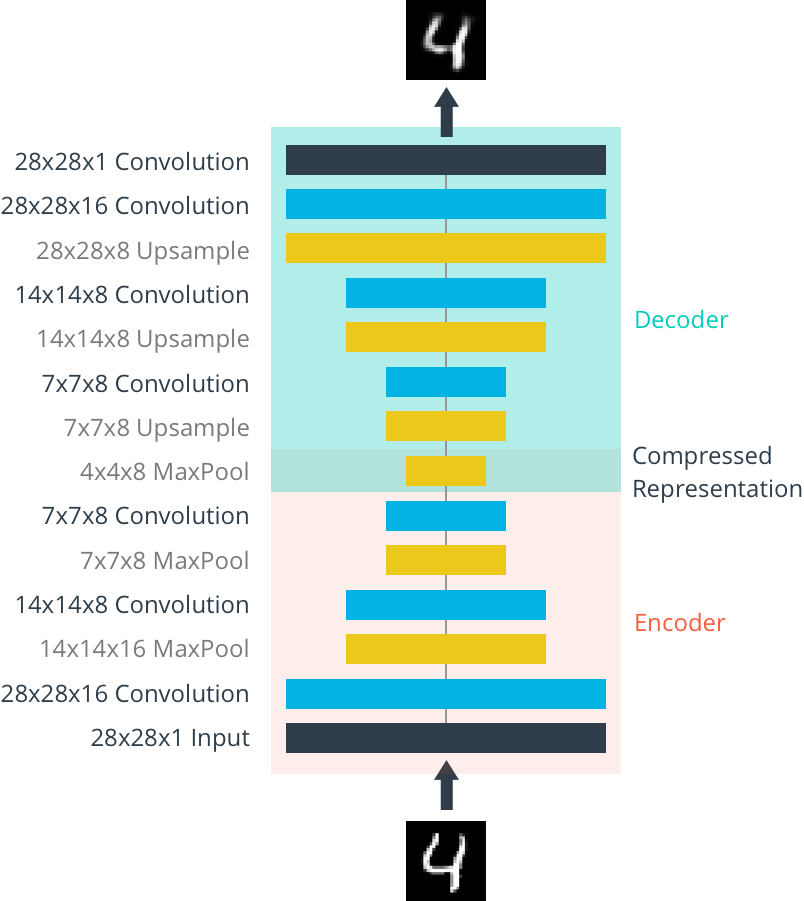

In [9]:
Image('https://raw.githubusercontent.com/udacity/\
deep-learning/master/autoencoder/assets/convolutional_autoencoder.png')

　　编码器的最后一层大小为 4x4x8 = 128。原始图片大小为 28x28 = 784，所以编码器向量大约只有原始图片大小的16%。这些只是每层的建议大小，可以自由调整深度和大小，但记住我们的目标是找到输入数据的最小压缩表示。

### 解码器
　　解码器有个 "Upsample" 层，但你之前可能没见过。首先，我会讨论这些层不是什么。通常，你会看到 **transposed convolution** 层用于增加该层的宽度和高度。它们的工作方式与卷积层几乎完全相同，但有点相反。输入层的步幅（stride）会导致转置卷积层的更大步幅。举例，假设有个 3x3 的卷积核核，输入层的一个 3x3 patch 通过卷积核，降维到卷积层的一个单元。相比之下，输入层的一个单元通过转置卷积层会扩充到 3x3 path。TensorFlow提供非常方便的方法创建转置卷积层， [`tf.nn.conv2d_transpose`](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose)。<br ?>
　　但是，转置卷积层会导致最后图像出现人造图像（lead to artifacts in the final images），如棋盘图案。这是由于卷积核的重叠，可以通过滑动窗口的步幅stride和卷积核的大小相等来避免。在[这篇文章](http://distill.pub/2016/deconv-checkerboard/) from Augustus Odena, *et al*, 作者表示可以通过使用最近邻或bilinear interpolation (upsampling) 在接卷积层，来避免。在TensorFlow，可以使用 [`tf.image.resize_images`](https://www.tensorflow.org/versions/r1.1/api_docs/python/tf/image/resize_images)，然后在接卷积层。想要更加明白解卷积层和为什么要使用upsampling可以阅读该文章。

In [8]:
inputs_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='targets')

# 编码，(28, 28, 1) -> (28, 28, 16)
conv1 = tf.layers.conv2d(inputs_, 16, (3, 3), padding='same', activation=tf.nn.relu)
# (28, 28, 16) -> (14, 14, 16)
maxpool1 = tf.layers.max_pooling2d(conv1, (2, 2), (2, 2), padding='same')
# (14, 14, 16) -> (14, 14, 8)
conv2 = tf.layers.conv2d(maxpool1, 8, (3, 3), padding='same', activation=tf.nn.relu)
# (14, 14, 8) -> (7, 7, 8)
maxpool2 = tf.layers.max_pooling2d(conv2, (2, 2), (2, 2), padding='same')
# (7, 7, 8) -> (7, 7, 8)
conv3 = tf.layers.conv2d(maxpool2, 8, (3, 3), padding='same', activation=tf.nn.relu)
# (7, 7, 8) -> (4, 4 8)
encoded = tf.layers.max_pooling2d(conv3, (2, 2), (2, 2), padding='same')

In [10]:
# 解码，(7, 7, 8)
upsample1 = tf.image.resize_nearest_neighbor(encoded, (7, 7))
# (7, 7, 8) -> (7, 7, 8)
conv4 = tf.layers.conv2d(upsample1, 8, (3, 3), padding='same', activation=tf.nn.relu)
# (7, 7, 8) -> (14, 14, 8)
upsample2 = tf.image.resize_nearest_neighbor(conv4, (14, 14))
# (14, 14, 8) -> (14, 14, 8)
conv5 = tf.layers.conv2d(upsample2, 8, (3, 3), padding='same', activation=tf.nn.relu)
# (14, 14, 8) -> (28, 28, 8)
upsample3 = tf.image.resize_nearest_neighbor(conv5, (28, 28))
# (28, 28, 8) -> (28, 28, 16)
conv6 = tf.layers.conv2d(upsample3, 16, (3, 3), padding='same', activation=tf.nn.relu)

logits = tf.layers.conv2d(conv6, 1, (3, 3), padding='same', activation=None)

In [11]:
decoded = tf.nn.sigmoid(logits, name='decoded')
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(0.001).minimize(cost)

## 训练
　　像之前那样，我们开始训练网络。这里我们直接传入 28x28x1 的数组，而不是将其展开成一列长的向量。

In [12]:
sess = tf.Session()

In [13]:
epochs = 20
batch_size = 200
sess.run(tf.global_variables_initializer())
for epoch in range(epochs):
    for i in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        imgs = batch[0].reshape((-1, 28, 28, 1))
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: imgs, targets_: imgs})
        print('Epoch: {} / {}'.format(epoch+1, epochs), 'Training loss: {:.4f}'.format(batch_cost))

Epoch: 1 / 20 Training loss: 0.7018
Epoch: 1 / 20 Training loss: 0.6971
Epoch: 1 / 20 Training loss: 0.6938
Epoch: 1 / 20 Training loss: 0.6915
Epoch: 1 / 20 Training loss: 0.6898
Epoch: 1 / 20 Training loss: 0.6885
Epoch: 1 / 20 Training loss: 0.6872
Epoch: 1 / 20 Training loss: 0.6859
Epoch: 1 / 20 Training loss: 0.6844
Epoch: 1 / 20 Training loss: 0.6828
Epoch: 1 / 20 Training loss: 0.6807
Epoch: 1 / 20 Training loss: 0.6782
Epoch: 1 / 20 Training loss: 0.6754
Epoch: 1 / 20 Training loss: 0.6723
Epoch: 1 / 20 Training loss: 0.6680
Epoch: 1 / 20 Training loss: 0.6629
Epoch: 1 / 20 Training loss: 0.6572
Epoch: 1 / 20 Training loss: 0.6499
Epoch: 1 / 20 Training loss: 0.6424
Epoch: 1 / 20 Training loss: 0.6318
Epoch: 1 / 20 Training loss: 0.6199
Epoch: 1 / 20 Training loss: 0.6097
Epoch: 1 / 20 Training loss: 0.5924
Epoch: 1 / 20 Training loss: 0.5768
Epoch: 1 / 20 Training loss: 0.5580
Epoch: 1 / 20 Training loss: 0.5415
Epoch: 1 / 20 Training loss: 0.5268
Epoch: 1 / 20 Training loss:

Epoch: 1 / 20 Training loss: 0.1727
Epoch: 1 / 20 Training loss: 0.1663
Epoch: 1 / 20 Training loss: 0.1695
Epoch: 1 / 20 Training loss: 0.1711
Epoch: 1 / 20 Training loss: 0.1645
Epoch: 1 / 20 Training loss: 0.1639
Epoch: 1 / 20 Training loss: 0.1711
Epoch: 1 / 20 Training loss: 0.1650
Epoch: 1 / 20 Training loss: 0.1645
Epoch: 1 / 20 Training loss: 0.1742
Epoch: 1 / 20 Training loss: 0.1688
Epoch: 1 / 20 Training loss: 0.1672
Epoch: 1 / 20 Training loss: 0.1733
Epoch: 1 / 20 Training loss: 0.1672
Epoch: 1 / 20 Training loss: 0.1610
Epoch: 1 / 20 Training loss: 0.1652
Epoch: 1 / 20 Training loss: 0.1651
Epoch: 1 / 20 Training loss: 0.1613
Epoch: 1 / 20 Training loss: 0.1595
Epoch: 1 / 20 Training loss: 0.1645
Epoch: 1 / 20 Training loss: 0.1665
Epoch: 1 / 20 Training loss: 0.1635
Epoch: 1 / 20 Training loss: 0.1663
Epoch: 1 / 20 Training loss: 0.1654
Epoch: 1 / 20 Training loss: 0.1613
Epoch: 1 / 20 Training loss: 0.1681
Epoch: 1 / 20 Training loss: 0.1676
Epoch: 1 / 20 Training loss:

Epoch: 2 / 20 Training loss: 0.1337
Epoch: 2 / 20 Training loss: 0.1404
Epoch: 2 / 20 Training loss: 0.1383
Epoch: 2 / 20 Training loss: 0.1382
Epoch: 2 / 20 Training loss: 0.1430
Epoch: 2 / 20 Training loss: 0.1418
Epoch: 2 / 20 Training loss: 0.1432
Epoch: 2 / 20 Training loss: 0.1433
Epoch: 2 / 20 Training loss: 0.1382
Epoch: 2 / 20 Training loss: 0.1394
Epoch: 2 / 20 Training loss: 0.1430
Epoch: 2 / 20 Training loss: 0.1422
Epoch: 2 / 20 Training loss: 0.1388
Epoch: 2 / 20 Training loss: 0.1435
Epoch: 2 / 20 Training loss: 0.1412
Epoch: 2 / 20 Training loss: 0.1388
Epoch: 2 / 20 Training loss: 0.1356
Epoch: 2 / 20 Training loss: 0.1373
Epoch: 2 / 20 Training loss: 0.1394
Epoch: 2 / 20 Training loss: 0.1415
Epoch: 2 / 20 Training loss: 0.1416
Epoch: 2 / 20 Training loss: 0.1356
Epoch: 2 / 20 Training loss: 0.1351
Epoch: 2 / 20 Training loss: 0.1413
Epoch: 2 / 20 Training loss: 0.1382
Epoch: 2 / 20 Training loss: 0.1394
Epoch: 2 / 20 Training loss: 0.1384
Epoch: 2 / 20 Training loss:

Epoch: 3 / 20 Training loss: 0.1264
Epoch: 3 / 20 Training loss: 0.1291
Epoch: 3 / 20 Training loss: 0.1305
Epoch: 3 / 20 Training loss: 0.1243
Epoch: 3 / 20 Training loss: 0.1336
Epoch: 3 / 20 Training loss: 0.1260
Epoch: 3 / 20 Training loss: 0.1258
Epoch: 3 / 20 Training loss: 0.1294
Epoch: 3 / 20 Training loss: 0.1283
Epoch: 3 / 20 Training loss: 0.1264
Epoch: 3 / 20 Training loss: 0.1209
Epoch: 3 / 20 Training loss: 0.1296
Epoch: 3 / 20 Training loss: 0.1317
Epoch: 3 / 20 Training loss: 0.1262
Epoch: 3 / 20 Training loss: 0.1308
Epoch: 3 / 20 Training loss: 0.1277
Epoch: 3 / 20 Training loss: 0.1312
Epoch: 3 / 20 Training loss: 0.1286
Epoch: 3 / 20 Training loss: 0.1302
Epoch: 3 / 20 Training loss: 0.1242
Epoch: 3 / 20 Training loss: 0.1311
Epoch: 3 / 20 Training loss: 0.1317
Epoch: 3 / 20 Training loss: 0.1257
Epoch: 3 / 20 Training loss: 0.1284
Epoch: 3 / 20 Training loss: 0.1282
Epoch: 3 / 20 Training loss: 0.1309
Epoch: 3 / 20 Training loss: 0.1293
Epoch: 3 / 20 Training loss:

Epoch: 4 / 20 Training loss: 0.1244
Epoch: 4 / 20 Training loss: 0.1188
Epoch: 4 / 20 Training loss: 0.1211
Epoch: 4 / 20 Training loss: 0.1203
Epoch: 4 / 20 Training loss: 0.1179
Epoch: 4 / 20 Training loss: 0.1227
Epoch: 4 / 20 Training loss: 0.1223
Epoch: 4 / 20 Training loss: 0.1209
Epoch: 4 / 20 Training loss: 0.1234
Epoch: 4 / 20 Training loss: 0.1212
Epoch: 4 / 20 Training loss: 0.1244
Epoch: 4 / 20 Training loss: 0.1236
Epoch: 4 / 20 Training loss: 0.1226
Epoch: 4 / 20 Training loss: 0.1197
Epoch: 4 / 20 Training loss: 0.1235
Epoch: 4 / 20 Training loss: 0.1206
Epoch: 4 / 20 Training loss: 0.1284
Epoch: 4 / 20 Training loss: 0.1172
Epoch: 4 / 20 Training loss: 0.1258
Epoch: 4 / 20 Training loss: 0.1251
Epoch: 4 / 20 Training loss: 0.1254
Epoch: 4 / 20 Training loss: 0.1265
Epoch: 4 / 20 Training loss: 0.1187
Epoch: 4 / 20 Training loss: 0.1169
Epoch: 4 / 20 Training loss: 0.1207
Epoch: 4 / 20 Training loss: 0.1233
Epoch: 4 / 20 Training loss: 0.1221
Epoch: 4 / 20 Training loss:

Epoch: 4 / 20 Training loss: 0.1193
Epoch: 4 / 20 Training loss: 0.1173
Epoch: 4 / 20 Training loss: 0.1207
Epoch: 4 / 20 Training loss: 0.1151
Epoch: 4 / 20 Training loss: 0.1163
Epoch: 4 / 20 Training loss: 0.1198
Epoch: 4 / 20 Training loss: 0.1169
Epoch: 4 / 20 Training loss: 0.1203
Epoch: 4 / 20 Training loss: 0.1199
Epoch: 4 / 20 Training loss: 0.1171
Epoch: 4 / 20 Training loss: 0.1216
Epoch: 4 / 20 Training loss: 0.1146
Epoch: 4 / 20 Training loss: 0.1173
Epoch: 4 / 20 Training loss: 0.1180
Epoch: 4 / 20 Training loss: 0.1183
Epoch: 4 / 20 Training loss: 0.1157
Epoch: 4 / 20 Training loss: 0.1152
Epoch: 4 / 20 Training loss: 0.1193
Epoch: 4 / 20 Training loss: 0.1230
Epoch: 4 / 20 Training loss: 0.1188
Epoch: 4 / 20 Training loss: 0.1154
Epoch: 4 / 20 Training loss: 0.1158
Epoch: 4 / 20 Training loss: 0.1191
Epoch: 4 / 20 Training loss: 0.1196
Epoch: 4 / 20 Training loss: 0.1163
Epoch: 4 / 20 Training loss: 0.1218
Epoch: 4 / 20 Training loss: 0.1122
Epoch: 4 / 20 Training loss:

Epoch: 5 / 20 Training loss: 0.1138
Epoch: 5 / 20 Training loss: 0.1181
Epoch: 5 / 20 Training loss: 0.1154
Epoch: 5 / 20 Training loss: 0.1163
Epoch: 5 / 20 Training loss: 0.1103
Epoch: 5 / 20 Training loss: 0.1183
Epoch: 5 / 20 Training loss: 0.1107
Epoch: 5 / 20 Training loss: 0.1152
Epoch: 5 / 20 Training loss: 0.1165
Epoch: 5 / 20 Training loss: 0.1136
Epoch: 5 / 20 Training loss: 0.1194
Epoch: 5 / 20 Training loss: 0.1147
Epoch: 5 / 20 Training loss: 0.1170
Epoch: 5 / 20 Training loss: 0.1158
Epoch: 5 / 20 Training loss: 0.1151
Epoch: 5 / 20 Training loss: 0.1118
Epoch: 5 / 20 Training loss: 0.1169
Epoch: 5 / 20 Training loss: 0.1151
Epoch: 5 / 20 Training loss: 0.1161
Epoch: 5 / 20 Training loss: 0.1145
Epoch: 5 / 20 Training loss: 0.1156
Epoch: 5 / 20 Training loss: 0.1147
Epoch: 5 / 20 Training loss: 0.1146
Epoch: 5 / 20 Training loss: 0.1169
Epoch: 5 / 20 Training loss: 0.1133
Epoch: 5 / 20 Training loss: 0.1127
Epoch: 5 / 20 Training loss: 0.1157
Epoch: 5 / 20 Training loss:

Epoch: 6 / 20 Training loss: 0.1132
Epoch: 6 / 20 Training loss: 0.1138
Epoch: 6 / 20 Training loss: 0.1141
Epoch: 6 / 20 Training loss: 0.1123
Epoch: 6 / 20 Training loss: 0.1100
Epoch: 6 / 20 Training loss: 0.1119
Epoch: 6 / 20 Training loss: 0.1143
Epoch: 6 / 20 Training loss: 0.1132
Epoch: 6 / 20 Training loss: 0.1133
Epoch: 6 / 20 Training loss: 0.1108
Epoch: 6 / 20 Training loss: 0.1159
Epoch: 6 / 20 Training loss: 0.1145
Epoch: 6 / 20 Training loss: 0.1162
Epoch: 6 / 20 Training loss: 0.1170
Epoch: 6 / 20 Training loss: 0.1117
Epoch: 6 / 20 Training loss: 0.1142
Epoch: 6 / 20 Training loss: 0.1151
Epoch: 6 / 20 Training loss: 0.1137
Epoch: 6 / 20 Training loss: 0.1134
Epoch: 6 / 20 Training loss: 0.1117
Epoch: 6 / 20 Training loss: 0.1127
Epoch: 6 / 20 Training loss: 0.1134
Epoch: 6 / 20 Training loss: 0.1096
Epoch: 6 / 20 Training loss: 0.1170
Epoch: 6 / 20 Training loss: 0.1103
Epoch: 6 / 20 Training loss: 0.1123
Epoch: 6 / 20 Training loss: 0.1180
Epoch: 6 / 20 Training loss:

Epoch: 7 / 20 Training loss: 0.1106
Epoch: 7 / 20 Training loss: 0.1089
Epoch: 7 / 20 Training loss: 0.1137
Epoch: 7 / 20 Training loss: 0.1109
Epoch: 7 / 20 Training loss: 0.1122
Epoch: 7 / 20 Training loss: 0.1076
Epoch: 7 / 20 Training loss: 0.1098
Epoch: 7 / 20 Training loss: 0.1118
Epoch: 7 / 20 Training loss: 0.1128
Epoch: 7 / 20 Training loss: 0.1080
Epoch: 7 / 20 Training loss: 0.1090
Epoch: 7 / 20 Training loss: 0.1134
Epoch: 7 / 20 Training loss: 0.1102
Epoch: 7 / 20 Training loss: 0.1086
Epoch: 7 / 20 Training loss: 0.1149
Epoch: 7 / 20 Training loss: 0.1109
Epoch: 7 / 20 Training loss: 0.1107
Epoch: 7 / 20 Training loss: 0.1109
Epoch: 7 / 20 Training loss: 0.1124
Epoch: 7 / 20 Training loss: 0.1125
Epoch: 7 / 20 Training loss: 0.1103
Epoch: 7 / 20 Training loss: 0.1106
Epoch: 7 / 20 Training loss: 0.1138
Epoch: 7 / 20 Training loss: 0.1127
Epoch: 7 / 20 Training loss: 0.1107
Epoch: 7 / 20 Training loss: 0.1164
Epoch: 7 / 20 Training loss: 0.1123
Epoch: 7 / 20 Training loss:

Epoch: 7 / 20 Training loss: 0.1097
Epoch: 7 / 20 Training loss: 0.1092
Epoch: 7 / 20 Training loss: 0.1127
Epoch: 7 / 20 Training loss: 0.1068
Epoch: 7 / 20 Training loss: 0.1135
Epoch: 7 / 20 Training loss: 0.1101
Epoch: 7 / 20 Training loss: 0.1089
Epoch: 7 / 20 Training loss: 0.1055
Epoch: 7 / 20 Training loss: 0.1083
Epoch: 7 / 20 Training loss: 0.1032
Epoch: 7 / 20 Training loss: 0.1087
Epoch: 7 / 20 Training loss: 0.1085
Epoch: 7 / 20 Training loss: 0.1084
Epoch: 7 / 20 Training loss: 0.1124
Epoch: 7 / 20 Training loss: 0.1082
Epoch: 7 / 20 Training loss: 0.1111
Epoch: 7 / 20 Training loss: 0.1134
Epoch: 7 / 20 Training loss: 0.1073
Epoch: 7 / 20 Training loss: 0.1075
Epoch: 7 / 20 Training loss: 0.1077
Epoch: 7 / 20 Training loss: 0.1122
Epoch: 7 / 20 Training loss: 0.1071
Epoch: 7 / 20 Training loss: 0.1092
Epoch: 7 / 20 Training loss: 0.1092
Epoch: 7 / 20 Training loss: 0.1145
Epoch: 7 / 20 Training loss: 0.1101
Epoch: 7 / 20 Training loss: 0.1098
Epoch: 7 / 20 Training loss:

Epoch: 8 / 20 Training loss: 0.1079
Epoch: 8 / 20 Training loss: 0.1052
Epoch: 8 / 20 Training loss: 0.1112
Epoch: 8 / 20 Training loss: 0.1066
Epoch: 8 / 20 Training loss: 0.1068
Epoch: 8 / 20 Training loss: 0.1102
Epoch: 8 / 20 Training loss: 0.1064
Epoch: 8 / 20 Training loss: 0.1050
Epoch: 8 / 20 Training loss: 0.1075
Epoch: 8 / 20 Training loss: 0.1102
Epoch: 8 / 20 Training loss: 0.1075
Epoch: 8 / 20 Training loss: 0.1053
Epoch: 8 / 20 Training loss: 0.1028
Epoch: 8 / 20 Training loss: 0.1051
Epoch: 8 / 20 Training loss: 0.1056
Epoch: 8 / 20 Training loss: 0.1064
Epoch: 8 / 20 Training loss: 0.1103
Epoch: 8 / 20 Training loss: 0.1133
Epoch: 8 / 20 Training loss: 0.1050
Epoch: 8 / 20 Training loss: 0.1098
Epoch: 8 / 20 Training loss: 0.1058
Epoch: 8 / 20 Training loss: 0.1095
Epoch: 8 / 20 Training loss: 0.1087
Epoch: 8 / 20 Training loss: 0.1062
Epoch: 8 / 20 Training loss: 0.1067
Epoch: 8 / 20 Training loss: 0.1074
Epoch: 8 / 20 Training loss: 0.1094
Epoch: 8 / 20 Training loss:

Epoch: 9 / 20 Training loss: 0.1097
Epoch: 9 / 20 Training loss: 0.1040
Epoch: 9 / 20 Training loss: 0.1062
Epoch: 9 / 20 Training loss: 0.1069
Epoch: 9 / 20 Training loss: 0.1060
Epoch: 9 / 20 Training loss: 0.1065
Epoch: 9 / 20 Training loss: 0.1033
Epoch: 9 / 20 Training loss: 0.1063
Epoch: 9 / 20 Training loss: 0.1098
Epoch: 9 / 20 Training loss: 0.1064
Epoch: 9 / 20 Training loss: 0.1090
Epoch: 9 / 20 Training loss: 0.1075
Epoch: 9 / 20 Training loss: 0.1058
Epoch: 9 / 20 Training loss: 0.1088
Epoch: 9 / 20 Training loss: 0.1087
Epoch: 9 / 20 Training loss: 0.1066
Epoch: 9 / 20 Training loss: 0.1107
Epoch: 9 / 20 Training loss: 0.1065
Epoch: 9 / 20 Training loss: 0.1031
Epoch: 9 / 20 Training loss: 0.1048
Epoch: 9 / 20 Training loss: 0.1058
Epoch: 9 / 20 Training loss: 0.1086
Epoch: 9 / 20 Training loss: 0.1069
Epoch: 9 / 20 Training loss: 0.1099
Epoch: 9 / 20 Training loss: 0.1104
Epoch: 9 / 20 Training loss: 0.1081
Epoch: 9 / 20 Training loss: 0.1111
Epoch: 9 / 20 Training loss:

Epoch: 10 / 20 Training loss: 0.1056
Epoch: 10 / 20 Training loss: 0.1054
Epoch: 10 / 20 Training loss: 0.1059
Epoch: 10 / 20 Training loss: 0.1153
Epoch: 10 / 20 Training loss: 0.1055
Epoch: 10 / 20 Training loss: 0.1047
Epoch: 10 / 20 Training loss: 0.1036
Epoch: 10 / 20 Training loss: 0.1049
Epoch: 10 / 20 Training loss: 0.1068
Epoch: 10 / 20 Training loss: 0.1064
Epoch: 10 / 20 Training loss: 0.1050
Epoch: 10 / 20 Training loss: 0.1059
Epoch: 10 / 20 Training loss: 0.1051
Epoch: 10 / 20 Training loss: 0.1034
Epoch: 10 / 20 Training loss: 0.1076
Epoch: 10 / 20 Training loss: 0.1047
Epoch: 10 / 20 Training loss: 0.1038
Epoch: 10 / 20 Training loss: 0.1088
Epoch: 10 / 20 Training loss: 0.1101
Epoch: 10 / 20 Training loss: 0.1059
Epoch: 10 / 20 Training loss: 0.1074
Epoch: 10 / 20 Training loss: 0.1079
Epoch: 10 / 20 Training loss: 0.1055
Epoch: 10 / 20 Training loss: 0.1057
Epoch: 10 / 20 Training loss: 0.1057
Epoch: 10 / 20 Training loss: 0.1074
Epoch: 10 / 20 Training loss: 0.1061
E

Epoch: 10 / 20 Training loss: 0.1047
Epoch: 10 / 20 Training loss: 0.1113
Epoch: 10 / 20 Training loss: 0.1082
Epoch: 10 / 20 Training loss: 0.1031
Epoch: 10 / 20 Training loss: 0.1008
Epoch: 10 / 20 Training loss: 0.1062
Epoch: 10 / 20 Training loss: 0.1025
Epoch: 10 / 20 Training loss: 0.1027
Epoch: 10 / 20 Training loss: 0.1078
Epoch: 10 / 20 Training loss: 0.1036
Epoch: 10 / 20 Training loss: 0.1054
Epoch: 10 / 20 Training loss: 0.1050
Epoch: 10 / 20 Training loss: 0.1038
Epoch: 10 / 20 Training loss: 0.1038
Epoch: 10 / 20 Training loss: 0.1059
Epoch: 10 / 20 Training loss: 0.1055
Epoch: 10 / 20 Training loss: 0.1035
Epoch: 10 / 20 Training loss: 0.1072
Epoch: 10 / 20 Training loss: 0.1033
Epoch: 10 / 20 Training loss: 0.1048
Epoch: 10 / 20 Training loss: 0.1085
Epoch: 10 / 20 Training loss: 0.1067
Epoch: 10 / 20 Training loss: 0.1016
Epoch: 10 / 20 Training loss: 0.1044
Epoch: 10 / 20 Training loss: 0.1043
Epoch: 10 / 20 Training loss: 0.1040
Epoch: 10 / 20 Training loss: 0.1026
E

Epoch: 11 / 20 Training loss: 0.1030
Epoch: 11 / 20 Training loss: 0.1054
Epoch: 11 / 20 Training loss: 0.1090
Epoch: 11 / 20 Training loss: 0.1044
Epoch: 11 / 20 Training loss: 0.1049
Epoch: 11 / 20 Training loss: 0.1081
Epoch: 11 / 20 Training loss: 0.1068
Epoch: 11 / 20 Training loss: 0.1050
Epoch: 11 / 20 Training loss: 0.1034
Epoch: 11 / 20 Training loss: 0.1041
Epoch: 11 / 20 Training loss: 0.1027
Epoch: 11 / 20 Training loss: 0.1036
Epoch: 11 / 20 Training loss: 0.1025
Epoch: 11 / 20 Training loss: 0.1069
Epoch: 11 / 20 Training loss: 0.1045
Epoch: 11 / 20 Training loss: 0.1053
Epoch: 11 / 20 Training loss: 0.1066
Epoch: 11 / 20 Training loss: 0.1071
Epoch: 11 / 20 Training loss: 0.1051
Epoch: 11 / 20 Training loss: 0.1048
Epoch: 11 / 20 Training loss: 0.1046
Epoch: 11 / 20 Training loss: 0.1054
Epoch: 11 / 20 Training loss: 0.1071
Epoch: 11 / 20 Training loss: 0.1014
Epoch: 11 / 20 Training loss: 0.1068
Epoch: 11 / 20 Training loss: 0.1052
Epoch: 11 / 20 Training loss: 0.1014
E

Epoch: 12 / 20 Training loss: 0.1067
Epoch: 12 / 20 Training loss: 0.1043
Epoch: 12 / 20 Training loss: 0.1045
Epoch: 12 / 20 Training loss: 0.1000
Epoch: 12 / 20 Training loss: 0.1055
Epoch: 12 / 20 Training loss: 0.1039
Epoch: 12 / 20 Training loss: 0.1035
Epoch: 12 / 20 Training loss: 0.1051
Epoch: 12 / 20 Training loss: 0.1051
Epoch: 12 / 20 Training loss: 0.0995
Epoch: 12 / 20 Training loss: 0.1052
Epoch: 12 / 20 Training loss: 0.1046
Epoch: 12 / 20 Training loss: 0.1088
Epoch: 12 / 20 Training loss: 0.1091
Epoch: 12 / 20 Training loss: 0.1056
Epoch: 12 / 20 Training loss: 0.1090
Epoch: 12 / 20 Training loss: 0.1061
Epoch: 12 / 20 Training loss: 0.1008
Epoch: 12 / 20 Training loss: 0.1049
Epoch: 12 / 20 Training loss: 0.1076
Epoch: 12 / 20 Training loss: 0.1030
Epoch: 12 / 20 Training loss: 0.1076
Epoch: 12 / 20 Training loss: 0.1033
Epoch: 12 / 20 Training loss: 0.0990
Epoch: 12 / 20 Training loss: 0.1031
Epoch: 12 / 20 Training loss: 0.1054
Epoch: 12 / 20 Training loss: 0.1062
E

Epoch: 13 / 20 Training loss: 0.1099
Epoch: 13 / 20 Training loss: 0.1020
Epoch: 13 / 20 Training loss: 0.1042
Epoch: 13 / 20 Training loss: 0.1038
Epoch: 13 / 20 Training loss: 0.1046
Epoch: 13 / 20 Training loss: 0.1050
Epoch: 13 / 20 Training loss: 0.1018
Epoch: 13 / 20 Training loss: 0.0975
Epoch: 13 / 20 Training loss: 0.1012
Epoch: 13 / 20 Training loss: 0.1046
Epoch: 13 / 20 Training loss: 0.1042
Epoch: 13 / 20 Training loss: 0.1007
Epoch: 13 / 20 Training loss: 0.1068
Epoch: 13 / 20 Training loss: 0.0989
Epoch: 13 / 20 Training loss: 0.1033
Epoch: 13 / 20 Training loss: 0.1020
Epoch: 13 / 20 Training loss: 0.1077
Epoch: 13 / 20 Training loss: 0.1025
Epoch: 13 / 20 Training loss: 0.1069
Epoch: 13 / 20 Training loss: 0.1047
Epoch: 13 / 20 Training loss: 0.1029
Epoch: 13 / 20 Training loss: 0.1040
Epoch: 13 / 20 Training loss: 0.1069
Epoch: 13 / 20 Training loss: 0.1048
Epoch: 13 / 20 Training loss: 0.1048
Epoch: 13 / 20 Training loss: 0.1046
Epoch: 13 / 20 Training loss: 0.1047
E

Epoch: 13 / 20 Training loss: 0.1054
Epoch: 13 / 20 Training loss: 0.1006
Epoch: 13 / 20 Training loss: 0.0993
Epoch: 13 / 20 Training loss: 0.1012
Epoch: 13 / 20 Training loss: 0.1028
Epoch: 13 / 20 Training loss: 0.1061
Epoch: 13 / 20 Training loss: 0.1006
Epoch: 13 / 20 Training loss: 0.1002
Epoch: 13 / 20 Training loss: 0.1030
Epoch: 13 / 20 Training loss: 0.1026
Epoch: 13 / 20 Training loss: 0.1005
Epoch: 13 / 20 Training loss: 0.1013
Epoch: 13 / 20 Training loss: 0.1049
Epoch: 13 / 20 Training loss: 0.1017
Epoch: 13 / 20 Training loss: 0.1009
Epoch: 13 / 20 Training loss: 0.1072
Epoch: 13 / 20 Training loss: 0.1041
Epoch: 13 / 20 Training loss: 0.1060
Epoch: 13 / 20 Training loss: 0.1060
Epoch: 13 / 20 Training loss: 0.1022
Epoch: 13 / 20 Training loss: 0.0997
Epoch: 13 / 20 Training loss: 0.1002
Epoch: 13 / 20 Training loss: 0.1038
Epoch: 13 / 20 Training loss: 0.1039
Epoch: 13 / 20 Training loss: 0.1008
Epoch: 13 / 20 Training loss: 0.1009
Epoch: 13 / 20 Training loss: 0.1005
E

Epoch: 14 / 20 Training loss: 0.1036
Epoch: 14 / 20 Training loss: 0.0997
Epoch: 14 / 20 Training loss: 0.1000
Epoch: 14 / 20 Training loss: 0.1040
Epoch: 14 / 20 Training loss: 0.1026
Epoch: 14 / 20 Training loss: 0.1051
Epoch: 14 / 20 Training loss: 0.0984
Epoch: 14 / 20 Training loss: 0.0998
Epoch: 14 / 20 Training loss: 0.1041
Epoch: 14 / 20 Training loss: 0.1017
Epoch: 14 / 20 Training loss: 0.1039
Epoch: 14 / 20 Training loss: 0.1038
Epoch: 14 / 20 Training loss: 0.0996
Epoch: 14 / 20 Training loss: 0.1027
Epoch: 14 / 20 Training loss: 0.1002
Epoch: 14 / 20 Training loss: 0.1048
Epoch: 14 / 20 Training loss: 0.1052
Epoch: 14 / 20 Training loss: 0.1003
Epoch: 14 / 20 Training loss: 0.1018
Epoch: 14 / 20 Training loss: 0.1020
Epoch: 14 / 20 Training loss: 0.1023
Epoch: 14 / 20 Training loss: 0.1006
Epoch: 14 / 20 Training loss: 0.0993
Epoch: 14 / 20 Training loss: 0.0958
Epoch: 14 / 20 Training loss: 0.1036
Epoch: 14 / 20 Training loss: 0.1038
Epoch: 14 / 20 Training loss: 0.0998
E

Epoch: 15 / 20 Training loss: 0.1015
Epoch: 15 / 20 Training loss: 0.1040
Epoch: 15 / 20 Training loss: 0.1030
Epoch: 15 / 20 Training loss: 0.1013
Epoch: 15 / 20 Training loss: 0.1064
Epoch: 15 / 20 Training loss: 0.1000
Epoch: 15 / 20 Training loss: 0.1040
Epoch: 15 / 20 Training loss: 0.1025
Epoch: 15 / 20 Training loss: 0.1011
Epoch: 15 / 20 Training loss: 0.1034
Epoch: 15 / 20 Training loss: 0.1022
Epoch: 15 / 20 Training loss: 0.1009
Epoch: 15 / 20 Training loss: 0.1007
Epoch: 15 / 20 Training loss: 0.1022
Epoch: 15 / 20 Training loss: 0.1015
Epoch: 15 / 20 Training loss: 0.1033
Epoch: 15 / 20 Training loss: 0.1025
Epoch: 15 / 20 Training loss: 0.1028
Epoch: 15 / 20 Training loss: 0.1018
Epoch: 15 / 20 Training loss: 0.1026
Epoch: 15 / 20 Training loss: 0.1003
Epoch: 15 / 20 Training loss: 0.1023
Epoch: 15 / 20 Training loss: 0.1034
Epoch: 15 / 20 Training loss: 0.1034
Epoch: 15 / 20 Training loss: 0.1049
Epoch: 15 / 20 Training loss: 0.1017
Epoch: 15 / 20 Training loss: 0.1003
E

Epoch: 16 / 20 Training loss: 0.1018
Epoch: 16 / 20 Training loss: 0.0988
Epoch: 16 / 20 Training loss: 0.1064
Epoch: 16 / 20 Training loss: 0.1051
Epoch: 16 / 20 Training loss: 0.1033
Epoch: 16 / 20 Training loss: 0.0968
Epoch: 16 / 20 Training loss: 0.1034
Epoch: 16 / 20 Training loss: 0.1032
Epoch: 16 / 20 Training loss: 0.1036
Epoch: 16 / 20 Training loss: 0.0991
Epoch: 16 / 20 Training loss: 0.1006
Epoch: 16 / 20 Training loss: 0.0997
Epoch: 16 / 20 Training loss: 0.1013
Epoch: 16 / 20 Training loss: 0.1012
Epoch: 16 / 20 Training loss: 0.1036
Epoch: 16 / 20 Training loss: 0.1032
Epoch: 16 / 20 Training loss: 0.1011
Epoch: 16 / 20 Training loss: 0.1034
Epoch: 16 / 20 Training loss: 0.1009
Epoch: 16 / 20 Training loss: 0.0995
Epoch: 16 / 20 Training loss: 0.1010
Epoch: 16 / 20 Training loss: 0.1035
Epoch: 16 / 20 Training loss: 0.0978
Epoch: 16 / 20 Training loss: 0.1048
Epoch: 16 / 20 Training loss: 0.1001
Epoch: 16 / 20 Training loss: 0.0980
Epoch: 16 / 20 Training loss: 0.1040
E

Epoch: 16 / 20 Training loss: 0.1037
Epoch: 16 / 20 Training loss: 0.0998
Epoch: 16 / 20 Training loss: 0.1020
Epoch: 16 / 20 Training loss: 0.1013
Epoch: 16 / 20 Training loss: 0.1017
Epoch: 16 / 20 Training loss: 0.1032
Epoch: 16 / 20 Training loss: 0.1022
Epoch: 16 / 20 Training loss: 0.1030
Epoch: 16 / 20 Training loss: 0.1029
Epoch: 16 / 20 Training loss: 0.1029
Epoch: 16 / 20 Training loss: 0.0994
Epoch: 16 / 20 Training loss: 0.1001
Epoch: 16 / 20 Training loss: 0.0997
Epoch: 16 / 20 Training loss: 0.1030
Epoch: 16 / 20 Training loss: 0.1054
Epoch: 16 / 20 Training loss: 0.0981
Epoch: 16 / 20 Training loss: 0.1001
Epoch: 16 / 20 Training loss: 0.1055
Epoch: 16 / 20 Training loss: 0.1019
Epoch: 16 / 20 Training loss: 0.1031
Epoch: 16 / 20 Training loss: 0.0993
Epoch: 16 / 20 Training loss: 0.1002
Epoch: 16 / 20 Training loss: 0.1019
Epoch: 16 / 20 Training loss: 0.1008
Epoch: 16 / 20 Training loss: 0.1008
Epoch: 16 / 20 Training loss: 0.1032
Epoch: 16 / 20 Training loss: 0.1033
E

Epoch: 17 / 20 Training loss: 0.1038
Epoch: 17 / 20 Training loss: 0.1000
Epoch: 17 / 20 Training loss: 0.1027
Epoch: 17 / 20 Training loss: 0.0997
Epoch: 17 / 20 Training loss: 0.1002
Epoch: 17 / 20 Training loss: 0.1009
Epoch: 17 / 20 Training loss: 0.1023
Epoch: 17 / 20 Training loss: 0.0983
Epoch: 17 / 20 Training loss: 0.1042
Epoch: 17 / 20 Training loss: 0.0983
Epoch: 17 / 20 Training loss: 0.1034
Epoch: 17 / 20 Training loss: 0.1071
Epoch: 17 / 20 Training loss: 0.0998
Epoch: 17 / 20 Training loss: 0.1019
Epoch: 17 / 20 Training loss: 0.0991
Epoch: 17 / 20 Training loss: 0.1030
Epoch: 17 / 20 Training loss: 0.0977
Epoch: 17 / 20 Training loss: 0.0974
Epoch: 17 / 20 Training loss: 0.0977
Epoch: 17 / 20 Training loss: 0.0994
Epoch: 17 / 20 Training loss: 0.1014
Epoch: 17 / 20 Training loss: 0.1034
Epoch: 17 / 20 Training loss: 0.1022
Epoch: 17 / 20 Training loss: 0.0999
Epoch: 17 / 20 Training loss: 0.1001
Epoch: 17 / 20 Training loss: 0.0975
Epoch: 17 / 20 Training loss: 0.0986
E

Epoch: 18 / 20 Training loss: 0.1005
Epoch: 18 / 20 Training loss: 0.1028
Epoch: 18 / 20 Training loss: 0.0999
Epoch: 18 / 20 Training loss: 0.1023
Epoch: 18 / 20 Training loss: 0.1030
Epoch: 18 / 20 Training loss: 0.0998
Epoch: 18 / 20 Training loss: 0.1032
Epoch: 18 / 20 Training loss: 0.0952
Epoch: 18 / 20 Training loss: 0.0996
Epoch: 18 / 20 Training loss: 0.1003
Epoch: 18 / 20 Training loss: 0.1042
Epoch: 18 / 20 Training loss: 0.0998
Epoch: 18 / 20 Training loss: 0.1055
Epoch: 18 / 20 Training loss: 0.0985
Epoch: 18 / 20 Training loss: 0.0993
Epoch: 18 / 20 Training loss: 0.1038
Epoch: 18 / 20 Training loss: 0.1006
Epoch: 18 / 20 Training loss: 0.0950
Epoch: 18 / 20 Training loss: 0.1009
Epoch: 18 / 20 Training loss: 0.1010
Epoch: 18 / 20 Training loss: 0.1045
Epoch: 18 / 20 Training loss: 0.0959
Epoch: 18 / 20 Training loss: 0.0997
Epoch: 18 / 20 Training loss: 0.1009
Epoch: 18 / 20 Training loss: 0.1027
Epoch: 18 / 20 Training loss: 0.1019
Epoch: 18 / 20 Training loss: 0.1046
E

Epoch: 18 / 20 Training loss: 0.1019
Epoch: 19 / 20 Training loss: 0.0995
Epoch: 19 / 20 Training loss: 0.1018
Epoch: 19 / 20 Training loss: 0.1021
Epoch: 19 / 20 Training loss: 0.1062
Epoch: 19 / 20 Training loss: 0.0999
Epoch: 19 / 20 Training loss: 0.1019
Epoch: 19 / 20 Training loss: 0.0981
Epoch: 19 / 20 Training loss: 0.1002
Epoch: 19 / 20 Training loss: 0.0963
Epoch: 19 / 20 Training loss: 0.0980
Epoch: 19 / 20 Training loss: 0.0993
Epoch: 19 / 20 Training loss: 0.0976
Epoch: 19 / 20 Training loss: 0.1027
Epoch: 19 / 20 Training loss: 0.1025
Epoch: 19 / 20 Training loss: 0.0978
Epoch: 19 / 20 Training loss: 0.0984
Epoch: 19 / 20 Training loss: 0.1036
Epoch: 19 / 20 Training loss: 0.1015
Epoch: 19 / 20 Training loss: 0.1026
Epoch: 19 / 20 Training loss: 0.0991
Epoch: 19 / 20 Training loss: 0.1005
Epoch: 19 / 20 Training loss: 0.0976
Epoch: 19 / 20 Training loss: 0.1025
Epoch: 19 / 20 Training loss: 0.1019
Epoch: 19 / 20 Training loss: 0.1016
Epoch: 19 / 20 Training loss: 0.0994
E

Epoch: 19 / 20 Training loss: 0.1002
Epoch: 19 / 20 Training loss: 0.1006
Epoch: 19 / 20 Training loss: 0.1020
Epoch: 19 / 20 Training loss: 0.1031
Epoch: 19 / 20 Training loss: 0.0950
Epoch: 19 / 20 Training loss: 0.1010
Epoch: 19 / 20 Training loss: 0.0960
Epoch: 19 / 20 Training loss: 0.0958
Epoch: 19 / 20 Training loss: 0.1007
Epoch: 19 / 20 Training loss: 0.0994
Epoch: 19 / 20 Training loss: 0.0991
Epoch: 19 / 20 Training loss: 0.1058
Epoch: 19 / 20 Training loss: 0.1009
Epoch: 19 / 20 Training loss: 0.0981
Epoch: 19 / 20 Training loss: 0.0993
Epoch: 19 / 20 Training loss: 0.1003
Epoch: 19 / 20 Training loss: 0.1002
Epoch: 19 / 20 Training loss: 0.0991
Epoch: 19 / 20 Training loss: 0.1012
Epoch: 19 / 20 Training loss: 0.1001
Epoch: 19 / 20 Training loss: 0.1032
Epoch: 19 / 20 Training loss: 0.1006
Epoch: 19 / 20 Training loss: 0.1025
Epoch: 19 / 20 Training loss: 0.0960
Epoch: 19 / 20 Training loss: 0.0954
Epoch: 19 / 20 Training loss: 0.1008
Epoch: 19 / 20 Training loss: 0.1021
E

Epoch: 20 / 20 Training loss: 0.1009
Epoch: 20 / 20 Training loss: 0.1003
Epoch: 20 / 20 Training loss: 0.1017
Epoch: 20 / 20 Training loss: 0.1022
Epoch: 20 / 20 Training loss: 0.0975
Epoch: 20 / 20 Training loss: 0.1037
Epoch: 20 / 20 Training loss: 0.0980
Epoch: 20 / 20 Training loss: 0.0980
Epoch: 20 / 20 Training loss: 0.0975
Epoch: 20 / 20 Training loss: 0.0982
Epoch: 20 / 20 Training loss: 0.0962
Epoch: 20 / 20 Training loss: 0.1027
Epoch: 20 / 20 Training loss: 0.0996
Epoch: 20 / 20 Training loss: 0.1000
Epoch: 20 / 20 Training loss: 0.0992
Epoch: 20 / 20 Training loss: 0.0977
Epoch: 20 / 20 Training loss: 0.0984
Epoch: 20 / 20 Training loss: 0.0994
Epoch: 20 / 20 Training loss: 0.0985
Epoch: 20 / 20 Training loss: 0.0997
Epoch: 20 / 20 Training loss: 0.0965
Epoch: 20 / 20 Training loss: 0.1010
Epoch: 20 / 20 Training loss: 0.0978
Epoch: 20 / 20 Training loss: 0.0961
Epoch: 20 / 20 Training loss: 0.0976
Epoch: 20 / 20 Training loss: 0.1001
Epoch: 20 / 20 Training loss: 0.0992
E

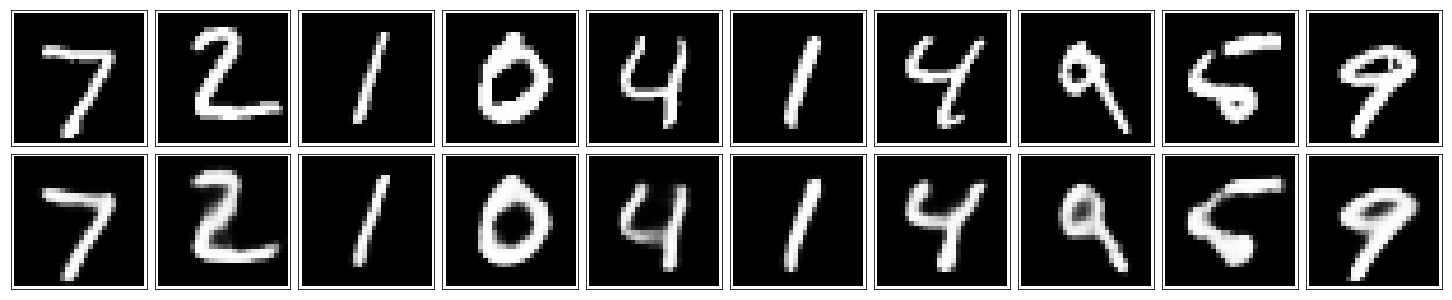

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
reconstructed = sess.run(decoded, feed_dict={inputs_: in_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


fig.tight_layout(pad=0.1)

In [16]:
sess.close()

## 去噪声
　　就像之前提到的，迄今为止建的自编码器并不是很有用。但是，只要在有噪声的图像上训练自编码，就可成功去除噪声。我们通过在训练图像中添加高斯噪声来创建噪声图像，然后将这些值剪切到0到1之间。我们将使用噪声图像作为输入，原始无噪声的图像作为y值。以下是生成的噪声图像和去除噪声图像的例子。

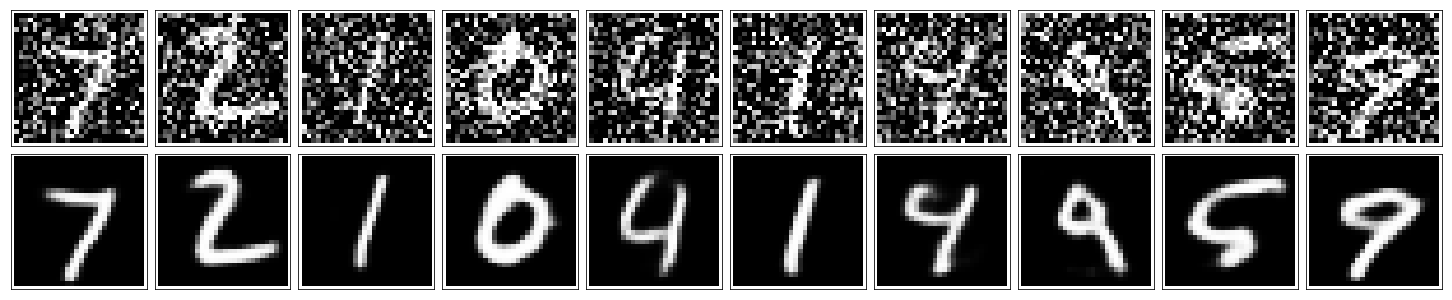

In [14]:
Image('https://github.com/udacity/deep-learning/raw/\
35ad0789cfb4a5d91e9adf8000f0b42be6d37c3b/autoencoder/assets/denoising.png')

　　因为这个问题对于网络来说是比较难的，所以我们使用更深的卷积网络和更多的卷积核。对于编码器中卷积层的深度，我建议像 32-32-16 这样，解码器的深度也一样。另外，架构与之前的一样。 

In [ ]:
inputs_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='targets')

#  编码，(28, 28, 1) -> (28, 28, 32)
conv1 = tf.layers.conv2d(inputs_, 32, (3,3), padding='same', activation=tf.nn.relu)
# (28, 28, 32) -> (14, 14, 32)
maxpool1 = tf.layers.max_pooling2d(conv1, (2,2), (2,2), padding='same')
# (14, 14, 32) -> (14, 14, 32)
conv2 = tf.layers.conv2d(maxpool1, 32, (3,3), padding='same', activation=tf.nn.relu)
# (14, 14, 32) -> (7, 7, 32)
maxpool2 = tf.layers.max_pooling2d(conv2, (2,2), (2,2), padding='same')
# (7, 7, 32) -> (7, 7, 16)
conv3 = tf.layers.conv2d(maxpool2, 16, (3,3), padding='same', activation=tf.nn.relu)
# (7, 7, 16) -> (4, 4, 16)
encoded = tf.layers.max_pooling2d(conv3, (2,2), (2,2), padding='same')

In [ ]:
# 解码，(4, 4, 16) -> (7, 7, 16)
upsample1 = tf.image.resize_nearest_neighbor(encoded, (7,7))
# (7, 7, 16) -> (7, 7, 16) 
conv4 = tf.layers.conv2d(upsample1, 16, (3,3), padding='same', activation=tf.nn.relu)
# (7, 7, 16)  -> (14, 14, 16) 
upsample2 = tf.image.resize_nearest_neighbor(conv4, (14,14))
# (14, 14, 16)  -> (14, 14, 32) 
conv5 = tf.layers.conv2d(upsample2, 32, (3,3), padding='same', activation=tf.nn.relu)
# (14, 14, 32)  -> (28, 28 32) 
upsample3 = tf.image.resize_nearest_neighbor(conv5, (28,28))
# (28, 28 32)  -> (28, 28 32) 
conv6 = tf.layers.conv2d(upsample3, 32, (3,3), padding='same', activation=tf.nn.relu)
# (28, 28 32)  -> (28, 28 , 1) 
logits = tf.layers.conv2d(conv6, 1, (3,3), padding='same', activation=None)
#Now 28x28x1

In [ ]:
decoded = tf.nn.sigmoid(logits, name='decoded')

loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(0.001).minimize(cost)

In [ ]:
sess = tf.Session()

In [ ]:
epochs = 100
batch_size = 200
# MNIST图像中添加多少噪声
noise_factor = 0.5
sess.run(tf.global_variables_initializer())
for epoch in range(epochs):
    for i in range(mnist.train.num_examples//batch_size):
        imgs = batch[0].reshape((-1, 28, 28, 1))
        
        # 对这些图片添加噪声
        noisy_imgs = imgs + noise_factor * np.random.randn(*imgs.shape)
        # 将图片clip到0和1之间
        noisy_imgs = np.clip(noisy_imgs, 0.0, 1.0)
        
        # 噪声图片作为输入，原始图片作为目标
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: noisy_imgs,
                                                         targets_: imgs})

        print('Epoch: {}/{}...'.format(e+1, epochs),
              'Training loss: {:.4f}'.format(batch_cost))

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
noisy_imgs = in_imgs + noise_factor * np.random.randn(*in_imgs.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

reconstructed = sess.run(decoded, feed_dict={inputs_: noisy_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([noisy_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)

## 总结
- 自编码是非监督，可用做去噪声。